**Байесовский классификатор: квадратичный дискриминант**

Евгений Борисов <esborisov@sevsu.ru>

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt

##  загружаем данные 

In [2]:
from sklearn.datasets import make_blobs

n_samples = 500
n_cls = 2

X,y = make_blobs( 
        n_samples=n_samples,
        centers=n_cls,  
        cluster_std=[1.0, 2.5,]
    )

lmbd = [ 1.1, ]*n_cls  # коэффициент "цены" ошибки

X.shape, y.shape

((500, 2), (500,))

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.5,)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((250, 2), (250,), (250, 2), (250,))

In [4]:
%xdel X
%xdel y

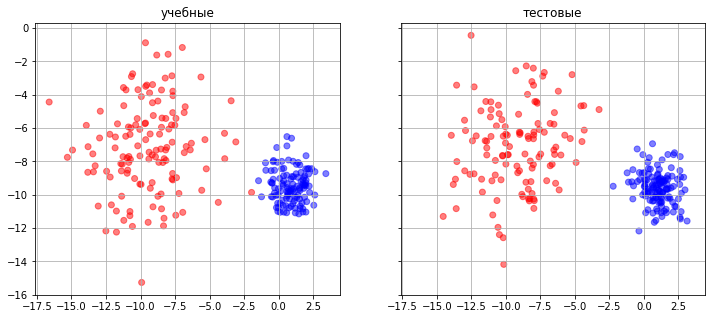

In [5]:
def plot_data(ax,X,y,t):
    c = [ ['b','r','g','y'][j] for j in y  ]
    ax.set_title(t)
    ax.scatter( x=X[:,0], y=X[:,1], c=c,  alpha=0.5 )
    ax.grid()

fig, (ax0,ax1) = plt.subplots(1,2, sharey=True, sharex=True, figsize=(12,5),)
plot_data(ax0,X_train,y_train,'учебные')    
plot_data(ax1,X_test,y_test,'тестовые')    
plt.show()

##  классификатор

$ 
a(x) = \underset{y\in Y}{\operatorname{argmax}} 
\left[ \ln(\lambda_y P_y) - \frac{1}{2} (x - \mu_y) \Sigma_y^{-1} (x-\mu_y)^T 
+  \frac{1}{2} \ln( |\Sigma_y^{-1}| ) \right] 
$

In [6]:
# априорные вероятности классов
Py = np.asarray([ (y_train==c).sum() for c in sorted(set(y_train)) ])
Py = Py/Py.sum()
Py

array([0.476, 0.524])

In [7]:
# мат.ожидания классов
mu = np.vstack([ X_train[y_train==y,:].mean(axis=0) for y in set(y_train) ] )
mu

array([[ 0.89625231, -9.47495572],
       [-9.43672595, -7.17707544]])

In [8]:
S = [ np.cov( X_train[y_train==y,:].T) for y in set(y_train) ]  # матрицы ковариаций классов
iS = [ np.linalg.inv(Sy) for Sy in S ] # обратные матрицы ковариаций классов

In [9]:
def bayes_score(X,mu,iS,lmbd):
    return np.vstack([ 
       np.log(lmbd[i]*Py[i]) 
        - 0.5*( (X-mu[i,:]).dot(iS[i])*(X-mu[i,:]) ).sum(axis=1) 
        + 0.5*np.linalg.norm(iS[i])
       for i in range(mu.shape[0])
    ])

In [10]:
def bayes(X,mu,iS,lmbd):
    return np.argmax( bayes_score(X,mu,iS,lmbd) ,axis=0)

##  результаты теста

In [11]:
o = bayes(X_test,mu,iS,lmbd)

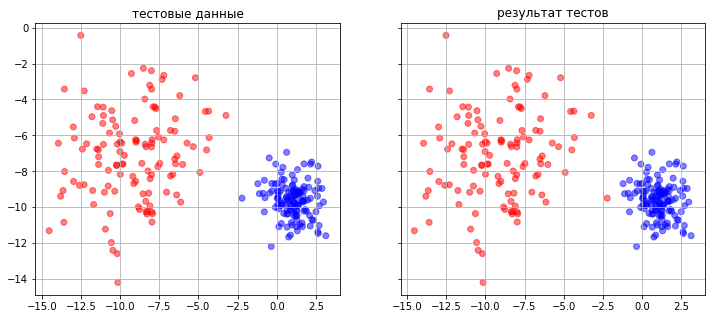

In [12]:
fig, (ax0,ax1) = plt.subplots(1,2, sharey=True, sharex=True, figsize=(12,5),)
plot_data(ax0,X_test,y_test,'тестовые данные')    
plot_data(ax1,X_test,o,'результат тестов')    
plt.show()

## метрики качества

In [15]:
from sklearn.metrics import classification_report
print( classification_report(y_test,o) )

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       131
           1       0.99      1.00      1.00       119

    accuracy                           1.00       250
   macro avg       1.00      1.00      1.00       250
weighted avg       1.00      1.00      1.00       250



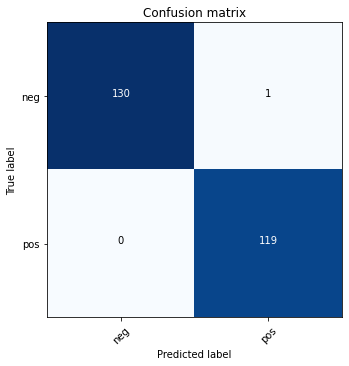

In [16]:
from sklearn.metrics import confusion_matrix
import itertools

cm = confusion_matrix(y_test,o)

classes = ['neg','pos']  if n_cls<3 else list(range(n_cls))
tick_marks = np.arange(len(classes))

plt.figure(figsize=(5,5))


plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

plt.title('Confusion matrix')

# # plt.colorbar()

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

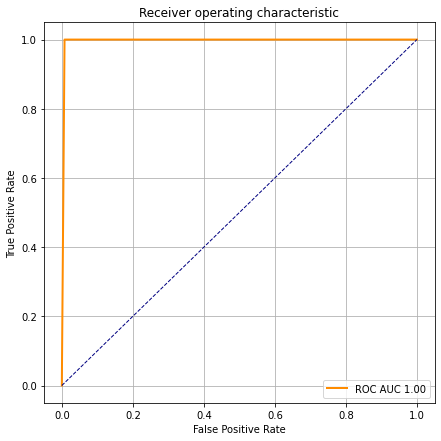

In [17]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

if n_cls<3:
    fpr, tpr, thresholds = roc_curve( y_test, o )
    roc_auc = auc(fpr,tpr)

    plt.figure(figsize=(7,7))
    plt.grid(True)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC AUC %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

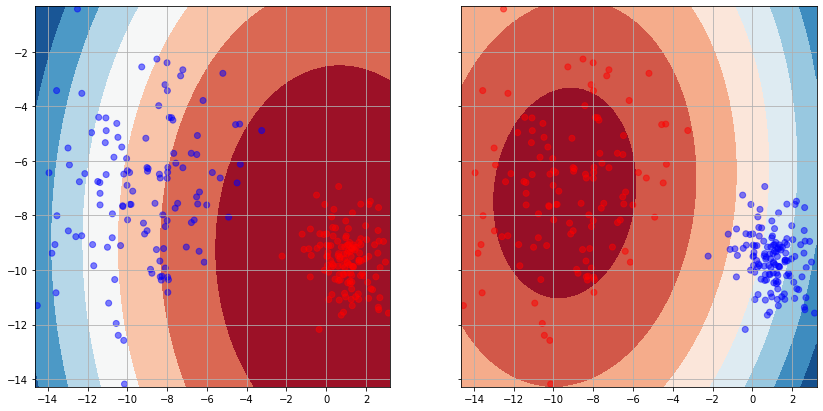

In [18]:
# строим сетку и определяем значения скора классификатора во всех узлах

n=50 # количество разбиений сетки

xx,yy = np.meshgrid(
    np.linspace( X_test[:,0].min()-0.1, X_test[:,0].max()+0.1, n), 
    np.linspace( X_test[:,1].min()-0.1, X_test[:,1].max()+0.1, n)
) # узлы сетки


xy = np.vstack([xx.ravel(),yy.ravel() ]).T # разворачиваем сетку 

xy.shape

bayes_score(xy,mu,iS,lmbd).T

pp = [ 
        bayes_score(xy,mu,iS,lmbd).T[:,n]
        for n in sorted(set(y_train)) 
    ]

n_cls=len(set(y_train))
ph=7
pw=ph*n_cls

f, axarr = plt.subplots(1,n_cls, sharey=True, sharex=True, figsize=(pw,ph),)
    
for c in sorted(set(y_train)):     
    clr = [ ['b','r'][ int(j==c) ] for j in y_test  ]
    axarr[c].contourf(xx, yy, 1.0-pp[c].reshape(n,n), cmap=plt.cm.RdBu)
    axarr[c].scatter( x=X_test[:,0], y=X_test[:,1], c=clr, alpha=.5 )
    axarr[c].grid()

plt.show()